https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

In [54]:
#!pip install mecab-python3
#!pip install unidic-lite
#!pip install --no-binary :all: mecab-python3
#!pip install torchtext==0.6.0
#!python -m spacy download ja_core_news_sm
#!python -m spacy download en_core_web_sm
#!python -m spacy link en_core_web_sm en
#!python -m spacy link ja_core_news_sm ja
#!pip install datasets


conda create -n rapids-24.06 -c rapidsai -c conda-forge -c nvidia  \
    rapids=24.06 python=3.11 'cuda-version>=12.0,<=12.2' \
    dask-sql jupyterlab dash graphistry tensorflow xarray-spatial 'pytorch=*=*cuda*'

load on server

#### steps to take to start server
 * step 1 open Ubuntu
 * steps 2 run conda init
 * step 3 run conda activate rapids-24.06
 * step 4 run jupyter notebook
 * step 5 (maybe?) run pip install jupyter

In [55]:
%load_ext cudf.pandas
import cudf.pandas
#cudf.pandas.install()
import pandas as pd

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [56]:
%reload_ext cudf.pandas
import cudf.pandas


In [57]:
import gc
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from numpy.random import shuffle
#from keras import preprocessing
import tensorflow as tf
from keras.utils import to_categorical
Tokenizer = tf.keras.preprocessing.text.Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.utils import plot_model

from keras.layers import Input, Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from keras.models import Sequential
#from keras.callbacks import ModelCheckpoint

from pickle import dump
from unicodedata import normalize
import cudf


/tmp/ipykernel_28284/3015446719.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

## load dataset

In [58]:
df=cudf.read_csv("split/train")
needtorow=df.columns[0]
df=df.rename(columns={needtorow:'text'})
df

,text
0,nothing thrills me more than to see kids polli...
1,do you want to spend all night at the cemetery...
2,our ships are in attack position.\t船はもう攻撃発起位置にある。
3,what about the original sam? huh?\tオリジナルの サムが居...
4,even though
...,...
2785853,what good would that have done?\t知って何の意味がある?
2785854,when ichinosukesan rushed over to ninosukesan....
2785855,your words are so encouraging.\tそういった お言葉を力に...。
2785856,goodbye


In [59]:
df=df.dropna()
df[["eng","jpn"]]=df['text'].str.split('\t',n=1, expand=True)
df=df.drop(['text'], axis=1)
df=df.dropna()
df=df.reset_index(drop=True)
df

,eng,jpn
0,nothing thrills me more than to see kids polli...,生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!
1,do you want to spend all night at the cemetery...,この雨の中 一晩中 墓地にいたい?
2,our ships are in attack position.,船はもう攻撃発起位置にある。
3,what about the original sam? huh?,オリジナルの サムが居るんだぞ
4,we will now begin the emergency captains' meet...,これより 緊急隊首会を行う。
...,...,...
2007888,that citizens and city governments around the ...,知る必要のある
2007889,what good would that have done?,知って何の意味がある?
2007890,when ichinosukesan rushed over to ninosukesan..,二之助さんに駆け寄った 一之助さんは
2007891,your words are so encouraging.,そういった お言葉を力に...。


In [60]:
import re
str = "I am a string with emoji 😍😍😱😱👿👿🐔🌚  ➡  and other Unicode characters 比如中文."
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
print(emoji_pattern.sub(r'', str)) # no emoji



I am a string with emoji     and other Unicode characters .


## cleaning data

In [61]:
import numpy as np
import re
english_column = []
for i in df['eng'].values_host:
    i=i.replace("?"," questionmark ").lower()
    i=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.", " ", i)
    i=i.replace(" t "," not ")
    i=i.replace(" ll "," will ")
    i=i.replace(" d "," had ")
    i=i.replace(" m "," am ")
    i=i.replace(" ve "," have ")
    i=i.replace(" s "," is ")
    i=i.replace(" re "," have ")
    i=i.replace("  "," ")
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    i=emoji_pattern.sub(r'', i)
    i='<sos> '+i
    english_column.append(i)
japanese_column=[]
for i in df['jpn'].values_host:
    list_of_syntax=["。",".","!","(",")","・","“"]
    i=i.replace("?","questionmark")
    for j in list_of_syntax:
        i=i.replace(j,"")
     
    i='<sos>'+i
    japanese_column.append(i)    
df['eng']=english_column
df['jpn']=japanese_column
df

,eng,jpn
0,<sos> nothing thrills me more than to see kids...,<sos>生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ
1,<sos> do you want to spend all night at the ce...,<sos>この雨の中 一晩中 墓地にいたいquestionmark
2,<sos> our ships are in attack position,<sos>船はもう攻撃発起位置にある
3,<sos> what about the original sam questionmark...,<sos>オリジナルの サムが居るんだぞ
4,<sos> we will now begin the emergency captains...,<sos>これより 緊急隊首会を行う
...,...,...
2007888,<sos> that citizens and city governments aroun...,<sos>知る必要のある
2007889,<sos> what good would that have done questionm...,<sos>知って何の意味があるquestionmark
2007890,<sos> when ichinosukesan rushed over to ninosu...,<sos>二之助さんに駆け寄った 一之助さんは
2007891,<sos> your words are so encouraging,<sos>そういった お言葉を力に


In [62]:
import MeCab

def jpnsplit(str,wakati):
    return wakati.parse(str).split()


In [63]:
jpn_space_sentence=[]
wakati = MeCab.Tagger("-Owakati")

for i in df['jpn'].to_pandas():
    split=jpnsplit(i,wakati)
    split=split[2:]
    split[0]="<sos>"
    jpn_space_sentence.append(split)
df['jpn']=jpn_space_sentence
df

,eng,jpn
0,<sos> nothing thrills me more than to see kids...,"[<sos>, 生徒, が, お, 互い, の, 受精, じゃ, なく, て, 植物, の,..."
1,<sos> do you want to spend all night at the ce...,"[<sos>, この, 雨, の, 中, 一, 晩, 中, 墓地, に, い, たい, qu..."
2,<sos> our ships are in attack position,"[<sos>, 船, は, もう, 攻撃, 発起, 位置, に, ある]"
3,<sos> what about the original sam questionmark...,"[<sos>, オリジナル, の, サム, が, 居る, ん, だ, ぞ]"
4,<sos> we will now begin the emergency captains...,"[<sos>, これ, より, 緊急, 隊, 首, 会, を, 行う]"
...,...,...
2007888,<sos> that citizens and city governments aroun...,"[<sos>, 知る, 必要, の, ある]"
2007889,<sos> what good would that have done questionm...,"[<sos>, 知っ, て, 何, の, 意味, が, ある, questionmark]"
2007890,<sos> when ichinosukesan rushed over to ninosu...,"[<sos>, 二, 之, 助, さん, に, 駆け寄っ, た, 一之助, さん, は]"
2007891,<sos> your words are so encouraging,"[<sos>, そう, いっ, た, お, 言葉, を, 力, に]"


In [64]:
eng_space_sentence=[]

for i in df['eng'].to_pandas():
    eng_space_sentence.append(i.split())
df['eng']=eng_space_sentence
df

,eng,jpn
0,"[<sos>, nothing, thrills, me, more, than, to, ...","[<sos>, 生徒, が, お, 互い, の, 受精, じゃ, なく, て, 植物, の,..."
1,"[<sos>, do, you, want, to, spend, all, night, ...","[<sos>, この, 雨, の, 中, 一, 晩, 中, 墓地, に, い, たい, qu..."
2,"[<sos>, our, ships, are, in, attack, position]","[<sos>, 船, は, もう, 攻撃, 発起, 位置, に, ある]"
3,"[<sos>, what, about, the, original, sam, quest...","[<sos>, オリジナル, の, サム, が, 居る, ん, だ, ぞ]"
4,"[<sos>, we, will, now, begin, the, emergency, ...","[<sos>, これ, より, 緊急, 隊, 首, 会, を, 行う]"
...,...,...
2007888,"[<sos>, that, citizens, and, city, governments...","[<sos>, 知る, 必要, の, ある]"
2007889,"[<sos>, what, good, would, that, have, done, q...","[<sos>, 知っ, て, 何, の, 意味, が, ある, questionmark]"
2007890,"[<sos>, when, ichinosukesan, rushed, over, to,...","[<sos>, 二, 之, 助, さん, に, 駆け寄っ, た, 一之助, さん, は]"
2007891,"[<sos>, your, words, are, so, encouraging]","[<sos>, そう, いっ, た, お, 言葉, を, 力, に]"


### another attempt

* conda install -c conda-forge spacy
* conda install -c conda-forge cupy
* python -m spacy download en_core_web_trf
* python -m spacy download ja_core_news_trf

## removing outleirs

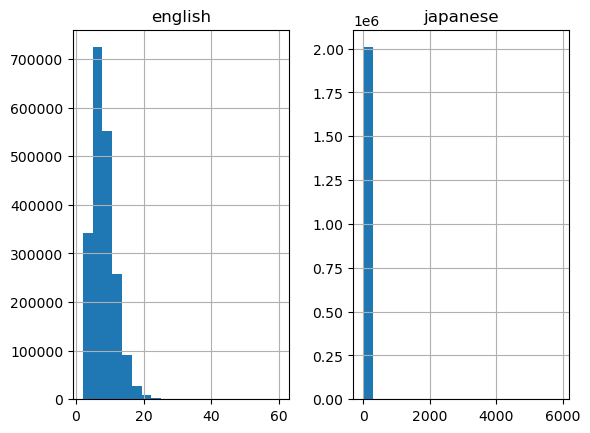

,english,japanese
0,15,20
1,15,13
2,7,9
3,9,9
4,9,9
...,...,...
2007888,9,5
2007889,8,9
2007890,7,11
2007891,6,9


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
eng_len = []
jpn_len = []

# populate the lists with sentence lengths
for i in df['eng'].to_arrow().tolist():
      eng_len.append(len(i))  
           
for i in df['jpn'].to_arrow().tolist():
      jpn_len.append(len(i))
length_df = pd.DataFrame({'english':eng_len, 'japanese':jpn_len})
length_df.hist(bins = 20)
plt.show()
length_df

In [66]:
from scipy.stats import zscore
length_df=length_df.apply(zscore)
zscoremax=3
df=df.drop(df[length_df['japanese'] >= zscoremax].index)
length_df=length_df.drop(length_df[length_df['japanese'] >= zscoremax].index)
df=df.drop(df[length_df['english'] >= zscoremax].index)
length_df=length_df.drop(length_df[length_df['english'] >= zscoremax].index)


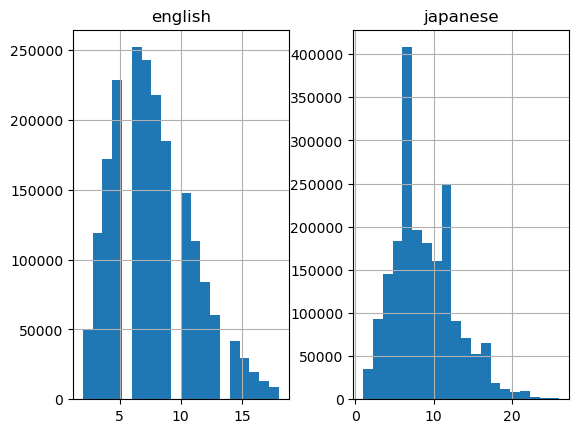

,english,japanese
0,15,20
1,15,13
2,7,9
3,9,9
4,9,9
...,...,...
1985662,9,5
1985663,8,9
1985664,7,11
1985665,6,9


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
eng_len = []
jpn_len = []

# populate the lists with sentence lengths
for i in df['eng'].to_arrow().tolist():
      eng_len.append(len(i))  
           
for i in df['jpn'].to_pandas():
      jpn_len.append(len(i))

length_df = pd.DataFrame({'english':eng_len, 'japanese':jpn_len})
length_df.hist(bins = 20)
plt.show()
length_df

# tokenization and padding

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
def get_max_value(eng_len,jpn_len):
    englength=max(eng_len)
    jpnlength=max(jpn_len)
    if(englength>=jpnlength):
        return englength
    else:
        return jpnlength
def pad_the_sentence(i,maxlen):
      if maxlen>=len(i):
            delta=maxlen-len(i)
            for x in range(delta):
                  i.append(' <eos>')
      return " ".join(i)



In [69]:
            
max_len=get_max_value(eng_len,jpn_len)
eng_col = []
jpn_col = []
# populate the lists with sentence lengths


for i in df['eng'].to_pandas():
      eng_col.append(pad_the_sentence(i,max_len))

df['eng']=eng_col
for i in df['jpn'].to_pandas():
      jpn_col.append(pad_the_sentence(i,max_len)) 
df['jpn']=jpn_col
df


,eng,jpn
0,<sos> nothing thrills me more than to see kids...,<sos> 生徒 が お 互い の 受精 じゃ なく て 植物 の 受粉 に 熱中 し て ...
1,<sos> do you want to spend all night at the ce...,<sos> この 雨 の 中 一 晩 中 墓地 に い たい questionmark <...
2,<sos> our ships are in attack position <eos> ...,<sos> 船 は もう 攻撃 発起 位置 に ある <eos> <eos> <eos...
3,<sos> what about the original sam questionmark...,<sos> オリジナル の サム が 居る ん だ ぞ <eos> <eos> <eo...
4,<sos> we will now begin the emergency captains...,<sos> これ より 緊急 隊 首 会 を 行う <eos> <eos> <eos>...
...,...,...
2007888,<sos> that citizens and city governments aroun...,<sos> 知る 必要 の ある <eos> <eos> <eos> <eos> ...
2007889,<sos> what good would that have done questionm...,<sos> 知っ て 何 の 意味 が ある questionmark <eos> <e...
2007890,<sos> when ichinosukesan rushed over to ninosu...,<sos> 二 之 助 さん に 駆け寄っ た 一之助 さん は <eos> <eos>...
2007891,<sos> your words are so encouraging <eos> <e...,<sos> そう いっ た お 言葉 を 力 に <eos> <eos> <eos> ...


In [70]:
import numpy as np
print(f'the min values for eng is {min(eng_len)} and the min values for jpn is {max(jpn_len)}')
print(f'the max values for eng is {max(eng_len)} and the max values for jpn is {max(jpn_len)}')
print(f'the mean values for eng is {np.mean(eng_len)} and the mean values for jpn is {np.mean(jpn_len)}')

the min values for eng is 2 and the min values for jpn is 26
the max values for eng is 18 and the max values for jpn is 26
the mean values for eng is 7.6229982167201245 and the mean values for jpn is 8.698189071984377


In [71]:
df=df[length_df['english']<=20]
df=df[length_df['japanese']<=20]
df

,eng,jpn
0,<sos> nothing thrills me more than to see kids...,<sos> 生徒 が お 互い の 受精 じゃ なく て 植物 の 受粉 に 熱中 し て ...
1,<sos> do you want to spend all night at the ce...,<sos> この 雨 の 中 一 晩 中 墓地 に い たい questionmark <...
2,<sos> our ships are in attack position <eos> ...,<sos> 船 は もう 攻撃 発起 位置 に ある <eos> <eos> <eos...
3,<sos> what about the original sam questionmark...,<sos> オリジナル の サム が 居る ん だ ぞ <eos> <eos> <eo...
4,<sos> we will now begin the emergency captains...,<sos> これ より 緊急 隊 首 会 を 行う <eos> <eos> <eos>...
...,...,...
2007888,<sos> that citizens and city governments aroun...,<sos> 知る 必要 の ある <eos> <eos> <eos> <eos> ...
2007889,<sos> what good would that have done questionm...,<sos> 知っ て 何 の 意味 が ある questionmark <eos> <e...
2007890,<sos> when ichinosukesan rushed over to ninosu...,<sos> 二 之 助 さん に 駆け寄っ た 一之助 さん は <eos> <eos>...
2007891,<sos> your words are so encouraging <eos> <e...,<sos> そう いっ た お 言葉 を 力 に <eos> <eos> <eos> ...


In [72]:
#df['eng'] = df['eng'].str.join(' ')
#df['jpn'] = df['jpn'].str.join(' ')

split the data set into train val and test

In [73]:
import sklearn
df = sklearn.utils.shuffle(df)
df = df.reset_index(drop=True)  
df

,eng,jpn
0,<sos> 4 years old <eos> <eos> <eos> <eos> ...,<sos> いく つ questionmark 4 歳 <eos> <eos> <eo...
1,<sos> i am in here <eos> <eos> <eos> <eos>...,<sos> 私 は 中 よ <eos> <eos> <eos> <eos> <eo...
2,<sos> time is up <eos> <eos> <eos> <eos> ...,<sos> その とき は <eos> <eos> <eos> <eos> <eo...
3,<sos> and here <eos> <eos> <eos> <eos> <e...,<sos> それ に ここ と ここ それ と ここ <eos> <eos> <eos...
4,<sos> isn not this police work questionmark <...,<sos> 仕事 し ねえ の か よ questionmark <eos> <eos>...
...,...,...
1970375,<sos> let is end it now <eos> <eos> <eos> ...,<sos> 今 だ みんな <eos> <eos> <eos> <eos> <eo...
1970376,<sos> a small team of doctors <eos> <eos> <...,<sos> 幸運 な こと に そこ に で は ハワード フローリー が 率いる <eo...
1970377,<sos> asshole <eos> <eos> <eos> <eos> <eo...,<sos> くそったれ <eos> <eos> <eos> <eos> <eos>...
1970378,<sos> we want your help <eos> <eos> <eos> ...,<sos> 手 を 貸し て ほしい の <eos> <eos> <eos> <eo...


In [74]:
# len of train will be 1959109 values
# len of val will be 6850
# len of test will be 6756
train_data=df.iloc[13606:,:]
print(train_data.shape)
val_test_data=df.iloc[:13606,:]
valid_data=val_test_data.iloc[6850:,:]
print(valid_data.shape)
test_data=val_test_data.iloc[:6850,:]
print(test_data.shape)

(1956774, 2)
(6756, 2)
(6850, 2)


In [75]:
test_data = test_data.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)   
test_data


,eng,jpn
0,<sos> 4 years old <eos> <eos> <eos> <eos> ...,<sos> いく つ questionmark 4 歳 <eos> <eos> <eo...
1,<sos> i am in here <eos> <eos> <eos> <eos>...,<sos> 私 は 中 よ <eos> <eos> <eos> <eos> <eo...
2,<sos> time is up <eos> <eos> <eos> <eos> ...,<sos> その とき は <eos> <eos> <eos> <eos> <eo...
3,<sos> and here <eos> <eos> <eos> <eos> <e...,<sos> それ に ここ と ここ それ と ここ <eos> <eos> <eos...
4,<sos> isn not this police work questionmark <...,<sos> 仕事 し ねえ の か よ questionmark <eos> <eos>...
...,...,...
6845,<sos> are you sure questionmark <eos> <eos> ...,<sos> まこと に 残念 です が <eos> <eos> <eos> <eos...
6846,<sos> over the last dozen years <eos> <eos> ...,<sos> 状況 が 大きく 変わり まし た <eos> <eos> <eos> ...
6847,<sos> is tastiness and healthfulness <eos> <...,<sos> 美味しい か 体 に 良い か だ と し ましょう <eos> <eos>...
6848,<sos> i will be finished <eos> <eos> <eos> ...,<sos> 終わる ん だ <eos> <eos> <eos> <eos> <eo...


In [76]:
from datasets import Dataset, features,DatasetDict
train_data_dic={'eng':train_data['eng'].to_arrow().tolist(),"jpn":train_data['jpn'].to_arrow().tolist()}
test_data_dic={'eng':test_data['eng'].to_arrow().tolist(),"jpn":test_data['jpn'].to_arrow().tolist()}
valid_data_dic={'eng':valid_data['eng'].to_arrow().tolist(),"jpn":valid_data['jpn'].to_arrow().tolist()}
Dataset.from_dict(train_data_dic).save_to_disk("dataset_jpn_eng.hf/train")
Dataset.from_dict(test_data_dic).save_to_disk("dataset_jpn_eng.hf/test")
Dataset.from_dict(valid_data_dic).save_to_disk("dataset_jpn_eng.hf/valid")


Saving the dataset (0/2 shards):   0%|          | 0/1956774 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6850 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6756 [00:00<?, ? examples/s]